In [2]:
from IPython.display import display
import tensorflow as tf
from keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

np.set_printoptions(precision=3, suppress=True)

Before applying any machine learning algorithms, I wanted to see how each of the given predictors relate to each other.
To do it, I have found out pairplot() function from seaborn library which takes the name of columns (predictors) as
parameters and plots each one of them with another.

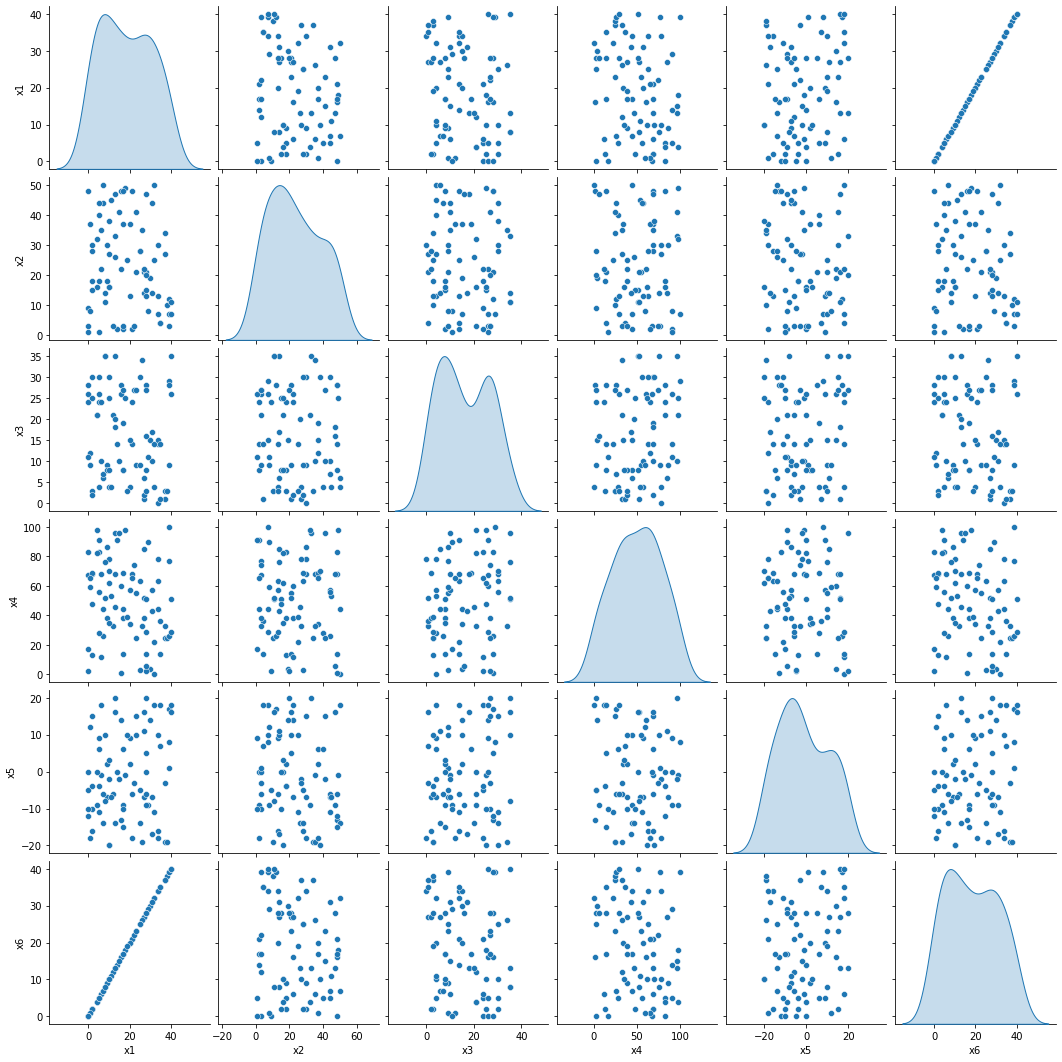

In [3]:
raw_dataset = pd.read_csv('dataset_v1.csv', sep=',', skipinitialspace=True)
dataset = raw_dataset.copy().dropna()

train_set = dataset.sample(frac=0.8, random_state=0)
test_set = dataset.drop(train_set.index)

sns.pairplot(train_set[['x1', 'x2', 'x3', 'x4', 'x5', 'x6']], diag_kind='kde')

From looking at the results, it is clear that x1 and x6 values are exactly the same. So, I have decided to drop x6
predictor since we do not need the same value twice.

Then, I wanted to see how each of those predictors relate to Y separately.

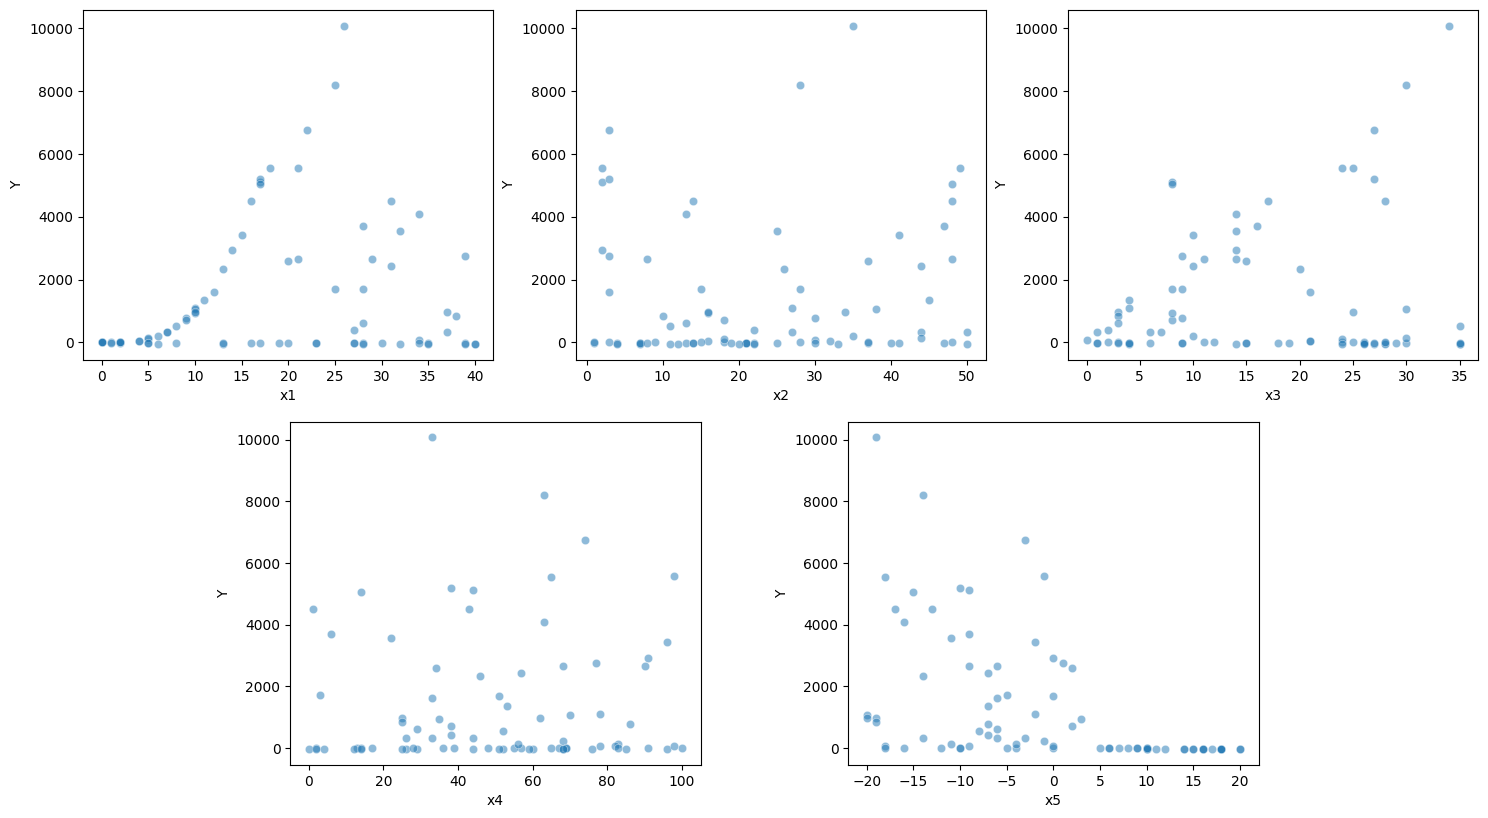

In [4]:
def scatter_plot_predictors(train_set_, y_, plot_func, predictors_):
    fig_, axes_ = plt.subplots(2, 3, figsize=(18, 10))
    axes_[1][2].set_visible(False)
    axes_[1][0].set_position([0.24, 0.125, 0.228, 0.343])
    axes_[1][1].set_position([0.55, 0.125, 0.228, 0.343])
    [plot_func(ax=axes_[i // 3, i % 3], x=train_set_[predictors_[i]], y=y_, alpha=0.5) for i in range(len(predictors_))]


train_set = train_set.drop('x6', axis=1)
test_set = test_set.drop('x6', axis=1)

predictors = ['x1', 'x2', 'x3', 'x4', 'x5']
scatter_plot_predictors(train_set, train_set['Y'], sns.scatterplot, predictors)

From here, I can see that when x1 has low values, their corresponding Y values are also tend to be low. Similarly,
when x5 has a value greater than 5, its corresponding Y value is very low.

The problem is, "very low" does not provide a clear metric,
so I have decided to examine "low" and "high" Y values separately.

<AxesSubplot:xlabel='SampleNo', ylabel='Y'>

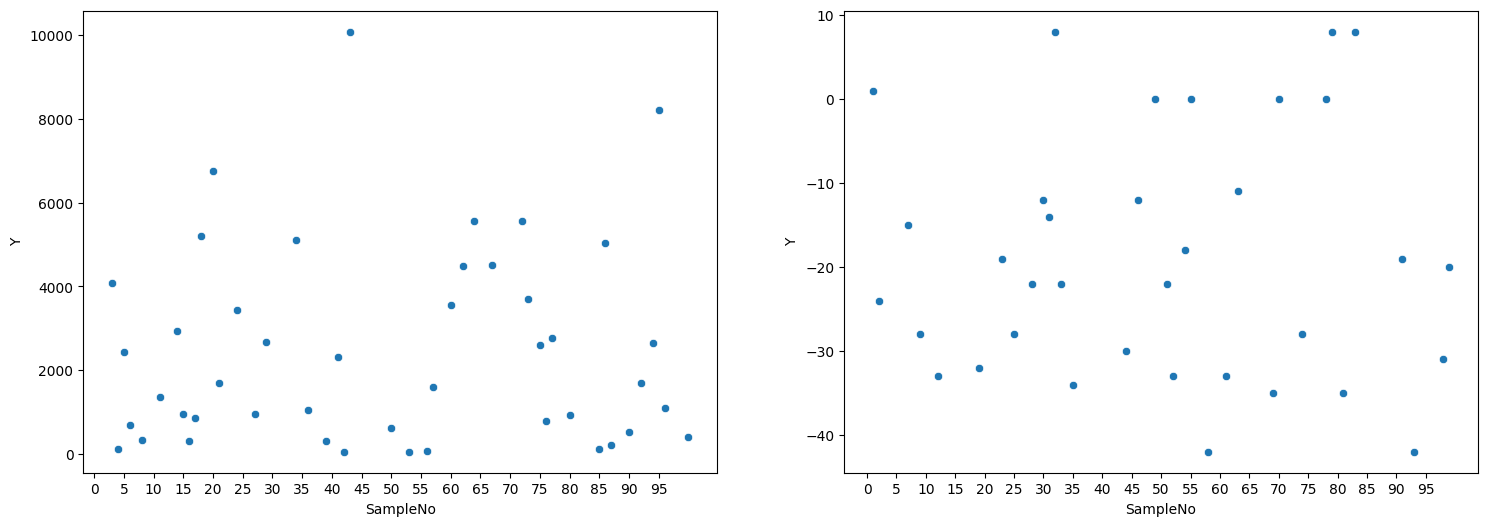

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
plt.setp(axes, xticks=np.arange(0, 100, 5))

limit = 50
lt_limit = train_set.copy()
lt_limit.drop(lt_limit[lt_limit['Y'] <= limit].index, inplace=True)
gt_limit = train_set.copy()
gt_limit.drop(gt_limit[gt_limit['Y'] > limit].index, inplace=True)

sns.scatterplot(ax=axes[0], x=lt_limit['SampleNo'], y=lt_limit['Y'])
sns.scatterplot(ax=axes[1], x=gt_limit['SampleNo'], y=gt_limit['Y'])

Separating points with Y values that are less than 50 from those are greater than 50 give those plots. It is not clear
that which model would fit those points the best, but it would be odd if it was that easy.

In [6]:
train_features = train_set.copy()
test_features = test_set.copy()

train_labels = train_features.pop('Y')
test_labels = test_features.pop('Y')

table_heuristics = train_set.describe().transpose()[['min', 'max', 'mean', 'std']]
display(table_heuristics)

,min,max,mean,std
SampleNo,1.0,100.0,49.4375,29.738031
x1,0.0,40.0,18.4875,12.347289
x2,1.0,50.0,23.2250,15.152370
x3,0.0,35.0,16.2000,10.501838
x4,0.0,100.0,49.9125,27.692339
x5,-20.0,20.0,-1.3000,11.841143
Y,-42.0,10077.0,1373.1375,2152.060218


# I. Single Linear Regression

## I.I. For x1

In [7]:
x1 = np.array(train_features['x1'])
x1_normalizer = layers.Normalization(input_shape=[1, ], axis=None)
x1_normalizer.adapt(x1)

x1_model = tf.keras.Sequential([x1_normalizer, layers.Dense(units=1)])

display(x1_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 1)                3         
 n)                                                              
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


None

In [8]:
# def rmse_error(y_actual, y_prediction):
#     return K.sqrt(K.mean(K.square(y_prediction - y_actual), axis=-1))

x1_model.predict(x1)
x1_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss='mean_absolute_error')

history = x1_model.fit(x=train_features['x1'],
                       y=train_labels,
                       epochs=200,
                       verbose=0,
                       validation_split=0.2)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
display(hist)

,loss,val_loss,epoch
0,1290.503540,1790.108521,0
1,1290.450928,1790.109375,1
2,1290.398315,1790.098633,2
3,1290.344360,1790.100098,3
4,1290.296387,1790.089355,4
...,...,...,...
195,1287.737305,1784.067871,195
196,1287.729370,1784.037109,196
197,1287.722168,1783.998169,197
198,1287.707764,1783.961182,198


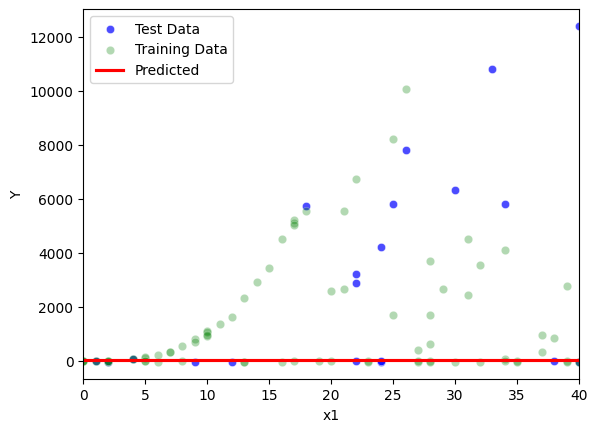

In [9]:
fig, ax = plt.subplots()
ax.set_xlim([table_heuristics['min']['x1'], table_heuristics['max']['x1']])

sns.scatterplot(ax=ax, x=test_features['x1'], y=test_labels,
                alpha=0.7, color='b', label='Test Data')
sns.scatterplot(ax=ax, x=train_features['x1'], y=train_labels,
                alpha=0.3, color='g', label='Training Data')

x = test_features['x1']
y_predict = x1_model.predict(x)

sns.regplot(ax=ax, x=test_features['SampleNo'], y=y_predict[:,0],
            color='r', scatter=False, truncate=False, label='Predicted')

plt.xlabel('x1')
plt.ylabel('Y')
plt.legend()

## I.II. For Every Input Predictor

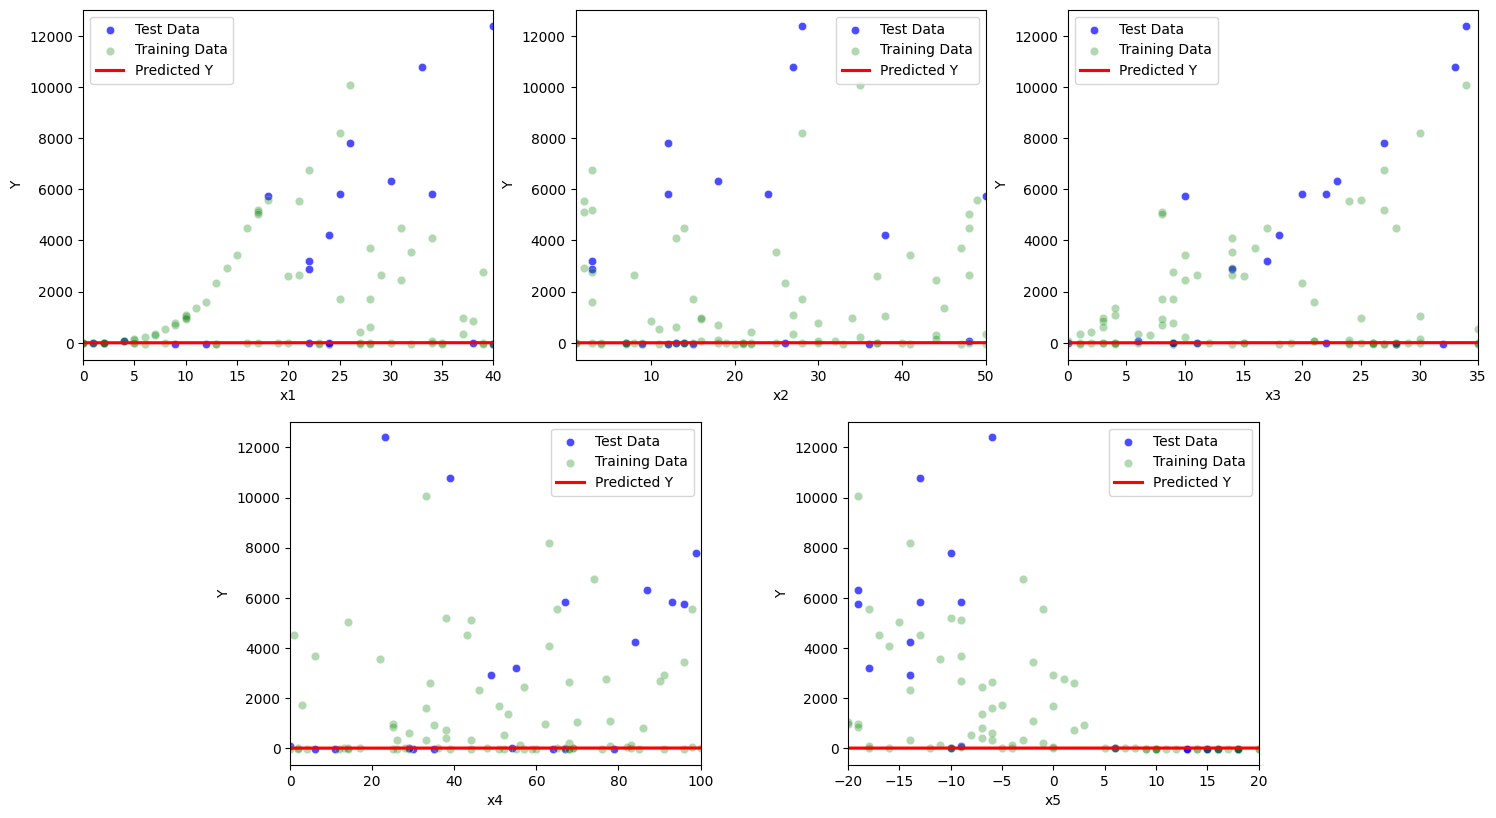

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes[1][2].set_visible(False)
axes[1][0].set_position([0.24, 0.125, 0.228, 0.343])
axes[1][1].set_position([0.55, 0.125, 0.228, 0.343])

test_results = {}

ax_i = 0
xi_normalizer = layers.Normalization(input_shape=[1, ], axis=None)

for p in predictors:
    ax = axes[ax_i // 3, ax_i % 3]

    xi = np.array(train_features[p])
    xi_normalizer.adapt(xi)

    xi_model = tf.keras.Sequential([xi_normalizer, layers.Dense(units=1)])
    xi_model.predict(xi)
    xi_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss='mean_absolute_error')

    test_results[p] = xi_model.evaluate(test_features[p], test_labels, verbose=0)

    x = test_features[p]
    y_predict = xi_model.predict(x)

    sns.scatterplot(ax=ax, x=test_features[p], y=test_labels,
                    alpha=0.7, color='b', label='Test Data')
    sns.scatterplot(ax=ax, x=train_features[p], y=train_labels,
                    alpha=0.3, color='g', label='Training Data')
    sns.regplot(ax=ax, x=x, y=y_predict,
                color='r', scatter=False, label='Predicted Y', truncate=False)
    ax.set_xlim(table_heuristics['min'][p], table_heuristics['max'][p])
    ax.set_xlabel(p)
    ax.set_ylabel('Y')
    ax.legend()
    ax_i += 1

## II. Multiple Linear Regression

In [11]:
mul_linreg = tf.keras.Sequential([tf.keras.layers.Normalization(axis=-1), layers.Dense(units=1)])

mul_linreg.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss='mean_absolute_error')

history = mul_linreg.fit(
    train_features,
    train_labels,
    epochs=200,
    verbose=0,
    validation_split=0.2)

test_results['mul_linreg'] = mul_linreg.evaluate(test_features, test_labels, verbose=0)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
display(hist)

,loss,val_loss,epoch
0,1328.083984,1810.450928,0
1,1304.894287,1790.618652,1
2,1294.780396,1778.005859,2
3,1286.831055,1770.569580,3
4,1282.528320,1764.049805,4
...,...,...,...
195,1126.469971,1581.128418,195
196,1126.381958,1580.631470,196
197,1126.377808,1580.296143,197
198,1126.509766,1580.063721,198


,9,12,21,25,36,37,39,44,46,47,58,64,65,67,70,81,83,87,88,96
Predicted,174.248184,824.887634,-262.305054,43.958939,-205.188599,657.010376,536.462708,-17.233107,-249.006638,684.240295,879.608093,986.856018,867.415344,-6.563094,48.535172,538.129822,673.423523,775.415466,1032.887451,836.32843
Actual,-13.000000,4222.000000,-37.000000,-32.000000,-33.000000,2897.000000,65.000000,-25.000000,-29.000000,7804.000000,10792.000000,6315.000000,5817.000000,-25.000000,-39.000000,1.000000,5812.000000,12402.000000,5733.000000,3204.00000


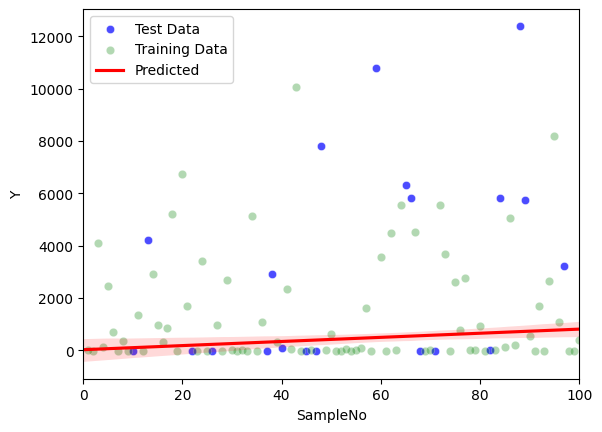

In [12]:
fig, ax = plt.subplots()
ax.set_xlim([0,100])

sns.scatterplot(ax=ax, x=test_features['SampleNo'], y=test_labels, alpha=0.7, color='b', label='Test Data')
sns.scatterplot(ax=ax, x=train_features['SampleNo'], y=train_labels, alpha=0.3, color='g', label='Training Data')

y_predict = mul_linreg.predict(test_features)
y_comparison = pd.DataFrame({'Predicted': y_predict[:,0],
                             'Actual': test_labels})
display(y_comparison.transpose())

sns.regplot(ax=ax, x=y_comparison.index, y=y_comparison['Predicted'], color='r',
            scatter=False, truncate=False, label='Predicted')

ax.set_xlabel('SampleNo')
ax.set_ylabel('Y')
ax.legend()

In [13]:
display(pd.DataFrame([[k, v] for k,v in test_results.items()], columns=['Model', 'MAE']))

,Model,MAE
0,x1,3264.679199
1,x2,3264.454346
2,x3,3264.411865
3,x4,3264.426270
4,x5,3265.629639
5,mul_linreg,2939.148193
